### STEP 1. 작업환경 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow',tf.__version__)

tensorflow 2.6.0


### STEP 2. 데이터셋 구성하기
    - 학습에 사용할 train_x 이미지를 -1,1로 정규화
    - 학습 데이터를 시각화 
    - from_tensor_slices()함수를 사용 미니배치 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print('max pixel:',train_x.max())
print('min pixel:',train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5)/127.5
# normalize image into [-1,1]

print('max pixel:',train_x.max())
print('min pixel:',train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x = train_x.reshape(train_x.shape[0],32,32,3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

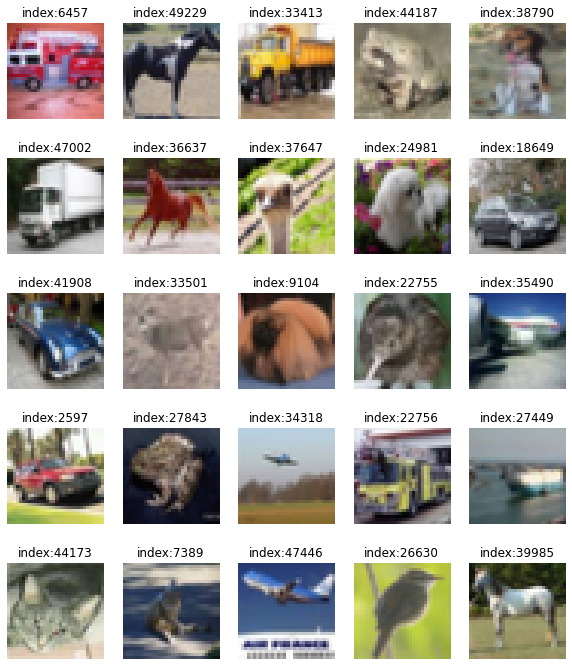

In [7]:
# visualize dataset
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    random = np.random.randint(len(train_x))
#     plt.imshow(train_x[random])
#     plt.imshow((train_x[random] * 255).astype(np.uint8))
    plt.imshow((train_x[random] * 127.5 +127.5).astype(np.int16))
    plt.title(f'index:{random}')
    plt.axis('off')
    
plt.show()


>이미지의 정규화를 진행 한 뒤에 시각화를 진행하려 했더니, warinning message 를 만났다. 
이미지의 값을 다시 0-255 로 돌려주어야 했다 

In [8]:
# mini batch
BUFFER_SIZE = 50000
BATCH_SIZE = 128
# train_x 를 자르는데, shuffle 해주시고, 미리 지정한 batch 사이즈로 잘라주세여
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기
- 32,32,3 의 shape 을 가진 이미지를 생성하는 생성자 모델 구현
- `noise = tf.random.normal([1,100])` 로 생성한 랜덤 노이즈를 입력으로 하여 이미지를 생성
- 생성된 이미지의 출력 규격 확인

In [9]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Dense Layer
    model.add(layers.Dense(8*8*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape Layer
    model.add(layers.Reshape((8,8,256)))
    
    # Third : Conv2DTanspose Layer
    model.add(layers.Conv2DTranspose(128,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose Layer
    model.add(layers.Conv2DTranspose(3,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    
    return model
    

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

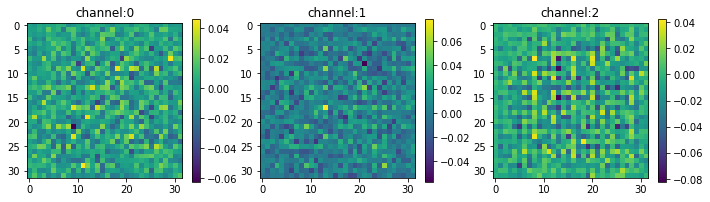

In [11]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
generated_image.shape

plt.figure(figsize=(16, 3))
for i in range(3) :
    plt.subplot(1, 4, i+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

### STEP 4.판별자 모델 구현하기
- 생성자 모델에서 생성한 이미지를 입력으로 받아, 1dim 을 가지는 판별 결과를 출력하는 판별자 모델 구현
- 랜덤 이미지를 판별한 판별자 모델의 결과값 확인 

In [12]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First : Conv2D Layer
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D Layer
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Third : Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth : Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [14]:
decision = discriminator(generated_image,training=False) # training=False????????
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00371228]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss) 를 구현
- 판별자의 출력을 가지고 실제/생성 이미지 판별 정확도를 계산하는 함수를 구현
- 생상자와 판별자를 최적화하는 optimizer 를 정의 

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [17]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def discriminator_accuracy(real_output,fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output,tf.constant([0.5])),tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output,tf.constant([0.5])),tf.float32))
    return real_accuracy,fake_accuracy

> 그동안 해오던 것 처럼 model.compile()을 이용해 loss 와 optimizer 를 지정하면 훨신 간단하고 편할텐데 왜 그렇게 하지 않는지 의문이 생겼다. 이유는 단지 우리는 여러개의 loss 와 accuracy 를 필요로 하며 model.compile()에서 제공하는 loss 와는 다른 loss 가 필요하기 때문이었다. 그래서 직접 모든 함수를 구현한다. 

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### STEP 6. 훈련과전 상세 기능 구현하기 
- 1개의 미니배치의 훈련과정을 처리하는 `train_step()`함수를 구현
- 16개의 고정된 seed 입력으로 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()`함수를 구현
- 매 epoch 마다 생성자 판별자의 loss 및 판별자의 실제/생성 이미지 판별 accuracy history를 그래프로 시각화 하는 `draw_train_history` 구현
- `training_checkpoints` 디렉토리에 몇 epoch 마다 모델을 저장하는 checkpoint 모듈을 설정

In [20]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
        real_accuracy , fake_accuracy = discriminator_accuracy(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    return gen_loss,disc_loss,real_accuracy,fake_accuracy

In [22]:
def generate_and_save_images(model,epoch,it,sample_seeds):
    
    predictions = model(sample_seeds,training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,:]+1)/2)
        # normalization (?)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:03d}.png'.format(os.getenv('HOME'),epoch,it))
    
    plt.show()

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [24]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### STEP 7. 학습 과정 진행하기 
- 최소 50에폭 이상 모델을 학습시킨다
- 학습과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현 
- 학습 과정을 담은 샘플 이미지,gif파일,학습진행 그래프 이미지를 함께 제출 

In [26]:
save_every = 10
EPOCHS = 300

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

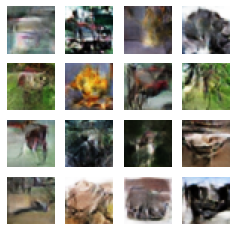

Time for training : 6329 sec


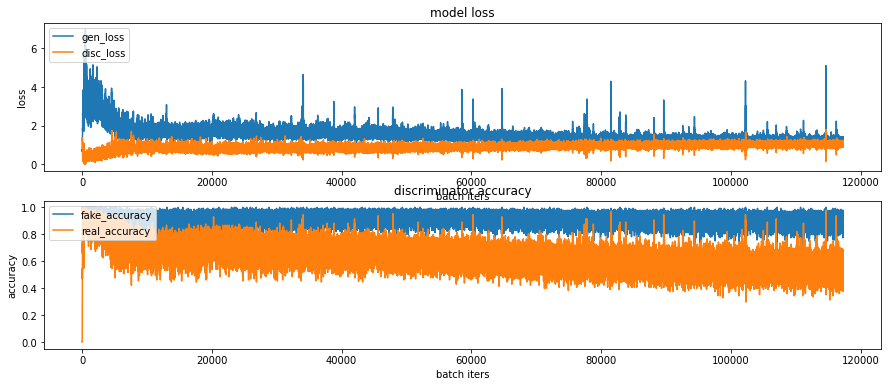

CPU times: user 1h 9min 46s, sys: 11min 36s, total: 1h 21min 23s
Wall time: 1h 45min 35s


In [27]:
%%time

train(train_dataset,EPOCHS,save_every)

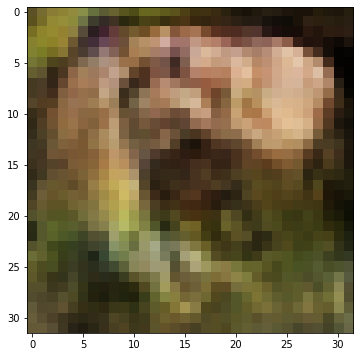

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1243491 Feb 14 09:46 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


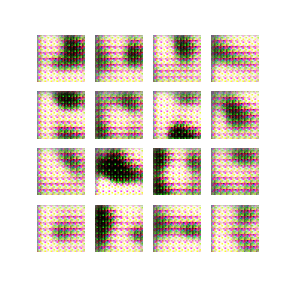

In [32]:
display.Image(filename = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif')

> 노드에서 제시한 기본 모델을 사용하고 300 epoch 으로 학습을 진행 했을때, 생성된 이미지가 나름 사진처럼 보이는 결과를 얻었으며, real accuracy 가 0.5 에 근접하게 내려갔다. 하지만 fake accuracy 는 변화가 거의 없는 아쉬운 부분이 있었다. 이
부분을 다음 스텝에서 개선해 보려고 한다.